# Classification of Pet's Real-Life Images

Lab Assignment from [AI for Beginners Curriculum](https://github.com/microsoft/ai-for-beginners).

Now it's time to deal with more challenging task - classification of the original [Oxford-IIIT Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/). Let's start by loading and visualizing the dataset.

In [11]:
import os

if not os.path.exists('images'):
    !wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
    !tar xfz images.tar.gz
    !rm images.tar.gz

We will define generic function to display a series of images from a list:

In [12]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import time

def display_images(l,titles=None,fontsize=12):
    n=len(l)
    fig,ax = plt.subplots(1,n)
    for i,im in enumerate(l):
        ax[i].imshow(im)
        ax[i].axis('off')
        if titles is not None:
            ax[i].set_title(titles[i],fontsize=fontsize)
    fig.set_size_inches(fig.get_size_inches()*n)
    plt.tight_layout()
    plt.show()

You can see that all images are located in one directory called `images`, and their name contains the name of the class (breed):

In [13]:
fnames = os.listdir('images')[:5]
display_images([Image.open(os.path.join('images',x)) for x in fnames],titles=fnames,fontsize=30)

IsADirectoryError: [Errno 21] Is a directory: 'images/wheaten_terrier'

To simplify classification and use the same approach to loading images as in the previous part, let's sort all images into corresponding directories:

In [15]:
for fn in os.listdir('images'):
    if os.path.isfile(os.path.join('images',fn)):
        cls = fn[:fn.rfind('_')].lower()
        os.makedirs(os.path.join('images',cls),exist_ok=True)
        os.replace(os.path.join('images',fn),os.path.join('images',cls,fn))

Let's also define the number of classes in our dataset:

In [5]:
num_classes = len(os.listdir('images'))
num_classes

38

## Preparing dataset for Deep Learning

To start training our neural network, we need to convert all images to tensors, and also create tensors corresponding to labels (class numbers). Most neural network frameworks contain simple tools for dealing with images:
* In Tensorflow, use `tf.keras.preprocessing.image_dataset_from_directory`
* In PyTorch, use `torchvision.datasets.ImageFolder`

As you have seen from the pictures above, all of them are close to square image ratio, so we need to resize all images to square size. Also, we can organize images in minibatches.

In [2]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as tf
from torch.utils.data import DataLoader, random_split

trans = tf.Compose([tf.Resize((256,256)),
                   tf.ToTensor()])

ds = torchvision.datasets.ImageFolder('images', transform=trans)
train_set, test_set = random_split(ds, [0.7,0.3])
print(len(train_set))


5173


Now we need to separate dataset into train and test portions:

Now define data loaders:

In [13]:
train_loader = DataLoader(train_set, batch_size=256, shuffle=True)
test_loader = DataLoader(test_set, batch_size=256, shuffle=True)

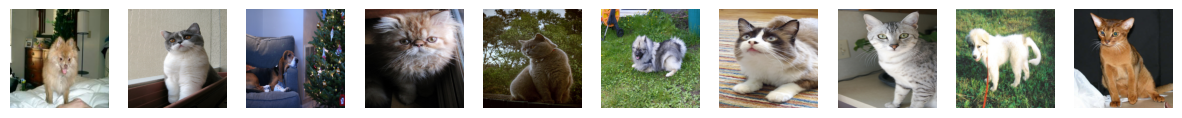

In [3]:
def display_dataset(dataset, n=10,classes=None):
    fig,ax = plt.subplots(1,n,figsize=(15,3))
    mn = min([dataset[i][0].min() for i in range(n)])
    mx = max([dataset[i][0].max() for i in range(n)])
    for i in range(n):
        ax[i].imshow(np.transpose((dataset[i][0]-mn)/(mx-mn),(1,2,0)))
        ax[i].axis('off')
        if classes:
            ax[i].set_title(classes[dataset[i][1]])

display_dataset(train_set)

## Define a neural network

For image classification, you should probably define a convolutional neural network with several layers. What to keep an eye for:
* Keep in mind the pyramid architecture, i.e. number of filters should increase as you go deeper
* Do not forget activation functions between layers (ReLU) and Max Pooling
* Final classifier can be with or without hidden layers, but the number of output neurons should be equal to number of classes.

An important thing is to get the activation function on the last layer + loss function right:
* In Tensorflow, you can use `softmax` as the activation, and `sparse_categorical_crossentropy` as loss. The difference between sparse categorical cross-entropy and non-sparse one is that the former expects output as the number of class, and not as one-hot vector.
* In PyTorch, you can have the final layer without activation function, and use `CrossEntropyLoss` loss function. This function applies softmax automatically. 

> **Hint:** In PyTorch, you can use `LazyLinear` layer instead of `Linear`, in order to avoid computing the number of inputs. It only requires one `n_out` parameter, which is number of neurons in the layer, and the dimension of input data is picked up automatically upon first `forward` pass.

In [18]:
class CNN(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.flatten = nn.Flatten(start_dim=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=16, kernel_size=(5,5),padding=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32,kernel_size=(3,3),padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), padding=1)
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), padding=1)
        self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3,3), padding=1)
        self.conv7 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,3), padding=1)
        self.conv8 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), padding=1)
        self.conv9 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3,3), padding=1)
        self.conv10 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3,3), padding=1)
        self.fc1 = nn.LazyLinear(out_features=3584)  
        self.fc2 = nn.Linear(in_features=3584,out_features=37)


    def forward(self,x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.pool(x)#dim out = 112x112
        x = self.relu(self.conv3(x)) 
        x = self.relu(self.conv4(x))
        x = self.pool(x) #dim out = 56x56
        x = self.relu(self.conv5(x))
        x = self.relu(self.conv6(x))
        x = self.pool(x) #dim out = 28x28
        x = self.relu(self.conv7(x))
        x = self.relu(self.conv8(x))
        x = self.pool(x) #dim out = 14x14
        x = self.relu(self.conv9(x))
        x = self.relu(self.conv10(x))
        x = self.pool(x) #dim out = 7x7
        x = self.relu(self.fc1(self.flatten(x)))
        x = self.relu(self.fc2(self.flatten(x)))
        return x

## Train the Neural Network

Now we are ready to train the neural network. During training, please collect accuracy on train and test data on each epoch, and then plot the accuracy to see if there is overfitting.

In [4]:
def train_epoch(model, loss_fn, dataloader, optimizer, report_freq, device):
    epoch_loss=[]
    running_loss = 0.0
    starttime = time.time()
    for j, (features, labels) in enumerate(dataloader):
            batch_starttime = time.time()
            optimizer.zero_grad(set_to_none=True)
            preds = model(features.to(device))
            lbls = labels.to(device)
            batch_loss = loss_fn(preds, lbls)
            batch_loss.backward()
            optimizer.step()
            epoch_loss.append(batch_loss.item())
            running_loss+=batch_loss.item()
            if j%report_freq==report_freq-1:
                print(f"Batch {j+1} finished, "
                      f"time = {int((time.time()-batch_starttime)/60)} minutes {round((time.time()-batch_starttime)%60,2)} seconds, "
                      f"loss: {running_loss/report_freq}")
                running_loss = 0.0
            else:
                print(f"Batch {j+1} finished, time = "
                      f"{int((time.time()-batch_starttime)/60)} minutes {round((time.time()-batch_starttime)%60,2)} seconds")
    return epoch_loss

def train_model(model, loss_fn,train_loader, test_loader, optimizer,no_of_epochs, report_freq, device='cpu'):
    train_loss = []
    val_loss = []
    accuracy = []
    for epoch in range(no_of_epochs):
        epoch_starttime = time.time()
        print(f"START TRAINING FOR EPOCH {epoch + 1}:")
        model.train(True)
        epoch_loss = train_epoch(model,loss_fn, train_loader, optimizer, report_freq, device)
        train_loss+=epoch_loss
            
        running_vloss = 0.0
        model.eval()
        print(f"Training for epoch {epoch+1} done, time = "
              f"{int((time.time()-epoch_starttime)/60)} minutes {round((time.time()-epoch_starttime)%60,2)} seconds")
        with torch.no_grad():
             for i, (vfeatures, vlabels) in enumerate(test_loader):
                  vbatch_starttime = time.time()
                  vpred = model(vfeatures)
                  vloss = loss_fn(vpred,vlabels)
                  correct = (torch.argmax(vpred, dim=1) == vlabels).type(torch.FloatTensor)
                  val_loss.append(vloss.item())
                  running_vloss+=vloss.item()
                  accuracy.append(correct.mean().item())
                  print(f"Completed validation for batch {i+1}, time = "
                        f"{int((time.time()-vbatch_starttime)/60)} minutes {round((time.time()-vbatch_starttime)%60,2)}"
                        f"seconds")
        

        val_loss.append(running_vloss/(i+1))
        train_loss+=epoch_loss
        print(f"Validation for epoch {epoch+1} done, time = "
              f"{int((time.time()-epoch_starttime)/60)} minutes {round((time.time()-epoch_starttime)%60,2)} seconds, "
              f"LOSS train {epoch_loss[-1]}, val: {val_loss[-1]}")

        
    return train_loss, val_loss, accuracy


    

In [19]:
net = CNN()
optim = torch.optim.Adam(net.parameters(), lr=0.001) #.SGD(net.parameters(), lr=0.001, momentum=0.9) #Adam(net.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
no_of_epochs = 3
train_loss, val_loss, acc = train_model(net, loss_fn=loss_fn, train_loader=train_loader, test_loader=test_loader, optimizer=optim,
                                        no_of_epochs=no_of_epochs, report_freq=5)
#train(net, train_loader=train_loader, test_loader=test_loader, optimizer=optim)

/usr/local/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


START TRAINING FOR EPOCH 1:
Batch 1 finished, time = 6 minutes 42.35 seconds
Batch 2 finished, time = 4 minutes 44.56 seconds
Batch 3 finished, time = 4 minutes 59.24 seconds
Batch 4 finished, time = 4 minutes 59.11 seconds
Batch 5 finished, time = 5 minutes 22.2 seconds, loss: 3.694641351699829
Batch 6 finished, time = 6 minutes 13.23 seconds
Batch 7 finished, time = 6 minutes 4.19 seconds
Batch 8 finished, time = 4 minutes 7.46 seconds
Batch 9 finished, time = 4 minutes 14.48 seconds
Batch 10 finished, time = 4 minutes 50.17 seconds, loss: 3.6120433807373047
Batch 11 finished, time = 5 minutes 46.19 seconds
Batch 12 finished, time = 5 minutes 46.37 seconds
Batch 13 finished, time = 5 minutes 11.93 seconds
Batch 14 finished, time = 5 minutes 33.15 seconds
Batch 15 finished, time = 4 minutes 28.0 seconds, loss: 3.6112672328948974
Batch 16 finished, time = 3 minutes 47.67 seconds
Batch 17 finished, time = 3 minutes 49.68 seconds
Batch 18 finished, time = 3 minutes 37.08 seconds
Batch 19

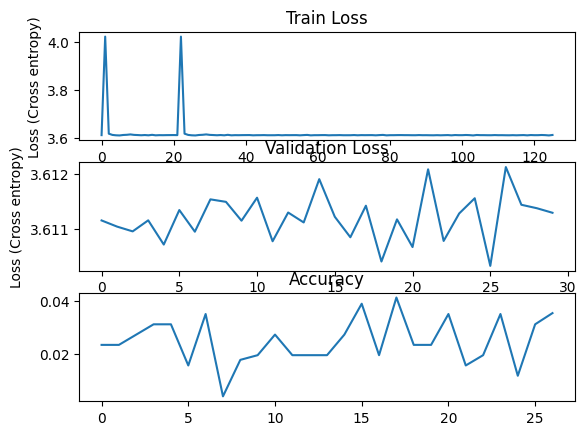

In [20]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1)

ax1.plot(train_loss)
ax1.set_ylabel("Loss (Cross entropy)")
ax1.set_title("Train Loss")

ax2.plot(val_loss)
ax2.set_ylabel("Loss (Cross entropy)")
ax2.set_title("Validation Loss")

ax3.plot(acc)
ax3.set_title("Accuracy")
plt.show()


Even if you have done everything correctly, you will probably see that the accuracy is quite low.

## Transfer Learning

To improve the accuracy, let's use pre-trained neural network as feature extractor. Feel free to experiment with VGG-16/VGG-19 models, ResNet50, etc.

> Since this training is slower, you may start with training the model for the small number of epochs, eg. 3. You can always resume training to further improve accuracy if needed.

We need to normalize our data differently for transfer learning, thus we will reload the dataset again using different set of transforms:

In [5]:
std_normalize = tf.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])

trans = tf.Compose([
        tf.Resize((256, 256)),
        tf.CenterCrop(244),
        tf.ToTensor(),
        #v2.ToDtype(torch.float32, scale=True),
        std_normalize
        ])

ds_vgg = torchvision.datasets.ImageFolder('images', transform=trans)
ds_vgg_train, ds_vgg_test = random_split(ds_vgg,[0.7,0.3])

Let's load the pre-trained network:

In [6]:
vgg = torchvision.models.vgg19(weights='DEFAULT')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print('Doing computations on device = {}'.format(device))

vgg.to(device)

Doing computations on device = cpu


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

Now define the classification model for your problem:
* In PyTorch, there is a slot called `classifier`, which you can replace with your own classifier for the desired number of classes.
* In TensorFlow, use VGG network as feature extractor, and build a `Sequential` model with VGG as first layer, and your own classifier on top

In [7]:
vgg.classifier = nn.Sequential(
                            nn.Linear(25088,3584),
                            nn.ReLU(),
                            nn.Linear(3584,37)).to(device)



Make sure to set all parameters of VGG feature extractor not to be trainable

In [8]:
for x in vgg.features.parameters():
    x.requires_grad = False

Now we can start the training. Be very patient, as training takes a long time, and our train function is not designed to print anything before the end of the epoch.

In [9]:
bs=256
train_loader_vgg = DataLoader(ds_vgg_train, batch_size=bs, shuffle=True)
test_loader_vgg = DataLoader(ds_vgg_test, batch_size=bs, shuffle=True)

optim = torch.optim.Adam(vgg.parameters(), lr=0.001) #.SGD(net.parameters(), lr=0.001, momentum=0.9) #Adam(net.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
no_of_epochs = 3
train_loss, val_loss, acc = train_model(vgg, loss_fn=loss_fn, train_loader=train_loader_vgg, test_loader=test_loader_vgg, optimizer=optim,
                                        no_of_epochs=no_of_epochs, report_freq=5)

START TRAINING FOR EPOCH 1:
Batch 1 finished, time = 12 minutes 57.8 seconds
Batch 2 finished, time = 8 minutes 50.55 seconds
Batch 3 finished, time = 7 minutes 45.81 seconds
Batch 4 finished, time = 7 minutes 55.9 seconds
Batch 5 finished, time = 7 minutes 29.34 seconds, loss: 6.316514539718628
Batch 6 finished, time = 7 minutes 37.15 seconds
Batch 7 finished, time = 7 minutes 38.61 seconds
Batch 8 finished, time = 7 minutes 28.12 seconds
Batch 9 finished, time = 7 minutes 16.24 seconds
Batch 10 finished, time = 7 minutes 58.68 seconds, loss: 2.9356664419174194
Batch 11 finished, time = 7 minutes 46.33 seconds
Batch 12 finished, time = 7 minutes 36.98 seconds
Batch 13 finished, time = 7 minutes 51.48 seconds
Batch 14 finished, time = 7 minutes 33.9 seconds
Batch 15 finished, time = 8 minutes 1.09 seconds, loss: 1.0970006704330444
Batch 16 finished, time = 7 minutes 39.96 seconds
Batch 17 finished, time = 7 minutes 27.56 seconds
Batch 18 finished, time = 7 minutes 29.47 seconds
Batch 1

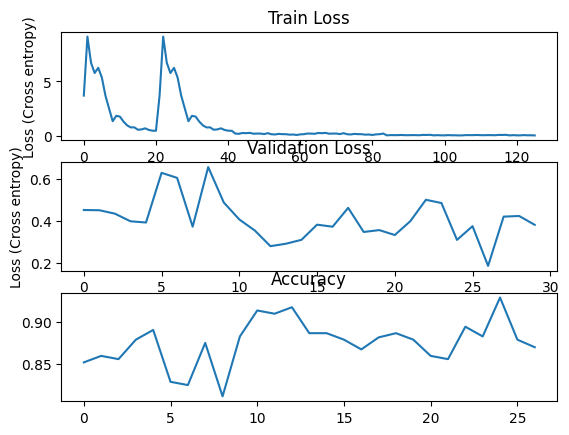

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1)

ax1.plot(train_loss)
ax1.set_ylabel("Loss (Cross entropy)")
ax1.set_title("Train Loss")

ax2.plot(val_loss)
ax2.set_ylabel("Loss (Cross entropy)")
ax2.set_title("Validation Loss")

ax3.plot(acc)
ax3.set_title("Accuracy")
plt.show()

It seems much better now!

## Optional: Calculate Top 3 Accuracy

We can also computer Top 3 accuracy using the same code as in the previous exercise.


In [18]:
# CALCULATE TOP-3 Accuracy of the model